### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
# # Install required libs

# ### please update Albumentations to version>=0.3.0 for `Lambda` transform support
# !pip install -U albumentations>=0.3.0 --user 
# !pip install -U --pre segmentation-models --user

# Loading dataset

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import shutil
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm as tqdm

Using TensorFlow backend.


In [3]:
training = False

In [4]:
data_folder_name = '0727_test_data/train_0727'
DATA_DIR = './{}'.format(data_folder_name)

set_size = 1024
set_padding = 1280

In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train/image')
y_train_dir = os.path.join(DATA_DIR, 'train/label')


# x_train_dir = os.path.join(DATA_DIR, 'training/train')
# y_train_dir = os.path.join(DATA_DIR, 'training/trainannot')

# x_valid_dir = os.path.join(DATA_DIR, 'val')
# y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test/image')
y_test_dir = os.path.join(DATA_DIR, 'test/label')

In [6]:
def remove_check_point(path):
    for file_name in os.listdir(path):
        #print(file_name)
        if 'checkpoints' in file_name:
            shutil.rmtree(os.path.join(path, file_name))
remove_check_point(x_train_dir)
remove_check_point(y_train_dir)

# Dataloader and utility functions 

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['img_whiteside','background','bacmixgums', 'artifical_crown','tooth','overlap','cavity','cej','gums','img_depressed']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(masks_dir)
        # for masks dir are smaller than imges_dir
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        #oupput image name
        name = self.images_fps[i].split('/')[-1]

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask, name
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


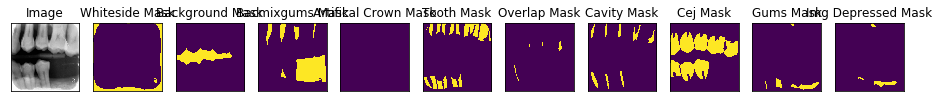

(1024, 1024, 3)


In [8]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes= ['img_whiteside','background','bacmixgums', 'artifical_crown','tooth','overlap','cavity','cej','gums','img_depressed'])
print(dataset.class_values)
image, mask,name = dataset[6] # get some sample

visualize(
    image=image, 
    whiteside_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
    bacmixgums_mask=mask[..., 3].squeeze(),
    artifical_crown_mask =mask[..., 4].squeeze(),
    tooth_mask =mask[..., 5].squeeze(),
    overlap_mask=mask[..., 6].squeeze(),
    cavity_mask =mask[..., 7].squeeze(),
    cej_mask=mask[..., 8].squeeze(),
    gums_mask =mask[..., 9].squeeze(),
    img_depressed_mask=mask[..., 10].squeeze(),
)
print(image.shape)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [9]:
import albumentations as A

In [10]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.3, rotate_limit=5, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=set_padding, min_width=set_padding, always_apply=True, border_mode=0),
        A.RandomCrop(height=set_size, width=set_size, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.5,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(set_padding, set_padding),
        A.RandomCrop(height=set_size, width=set_size, always_apply=True)
    ]
    return A.Compose(test_transform)

def get_training_enhance_augmentation():
    """Add paddings to make image shape divisible by 32"""
    fine_tune_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=90, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=set_padding, min_width=set_padding, always_apply=True, border_mode=0),
        A.RandomCrop(height=set_size, width=set_size, always_apply=True),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        )
    ]
    return A.Compose(fine_tune_transform)

def get_fine_tune_augmentation():
    """Add paddings to make image shape divisible by 32"""
    fine_tune_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=set_padding, min_width=set_padding, always_apply=True, border_mode=0),
        A.RandomCrop(height=set_size, width=set_size, always_apply=True),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.5,
        )
    ]
    return A.Compose(fine_tune_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


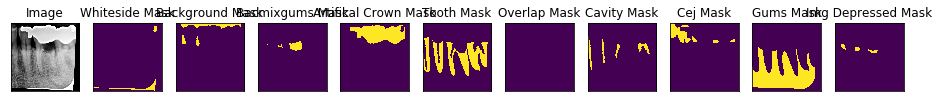

(1024, 1024, 3)


In [11]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes= ['img_whiteside','background','bacmixgums', 'artifical_crown','tooth','overlap','cavity','cej','gums','img_depressed'], augmentation=get_training_augmentation())
print(dataset.class_values)
image, mask,name = dataset[1] # get some sample

visualize(
    image=image, 
    whiteside_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
    bacmixgums_mask=mask[..., 3].squeeze(),
    artifical_crown_mask =mask[..., 4].squeeze(),
    tooth_mask =mask[..., 5].squeeze(),
    overlap_mask=mask[..., 6].squeeze(),
    cavity_mask =mask[..., 7].squeeze(),
    cej_mask=mask[..., 8].squeeze(),
    gums_mask =mask[..., 9].squeeze(),
    img_depressed_mask=mask[..., 10].squeeze(),
)
print(image.shape)

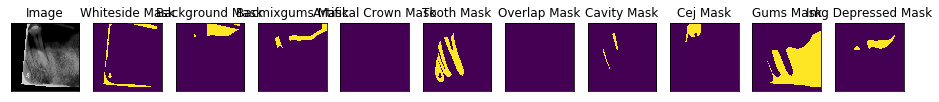

(1024, 1024, 3)


In [12]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['img_whiteside','background','bacmixgums', 'artifical_crown','tooth','overlap','cavity','cej','gums','img_depressed'], augmentation=get_fine_tune_augmentation())

image, mask,name = dataset[30] # get some sample
visualize(
    image=image, 
    whiteside_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
    bacmixgums_mask=mask[..., 3].squeeze(),
    artifical_crown_mask =mask[..., 4].squeeze(),
    tooth_mask =mask[..., 5].squeeze(),
    overlap_mask=mask[..., 6].squeeze(),
    cavity_mask =mask[..., 7].squeeze(),
    cej_mask=mask[..., 8].squeeze(),
    gums_mask =mask[..., 9].squeeze(),
    img_depressed_mask=mask[..., 10].squeeze(),
)
print(image.shape)

# Segmentation model training

In [13]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [14]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 2
CLASSES = ['img_whiteside','background','bacmixgums', 'artifical_crown','tooth','overlap','cavity','cej','gums','img_depressed']
#['background','bacmixgums', 'artifical_crown','tooth','gums','overlap','cavity','cej']
LR = 0.0001
EPOCHS = 100

preprocess_input = sm.get_preprocessing(BACKBONE)

In [15]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'
#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [16]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 1, 1, 1.5, 1.5, 2, 2,3,3,3,5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [17]:
# Dataset for train images


train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# # Dataset for validation images
# valid_dataset = Dataset(
#     x_valid_dir, 
#     y_valid_dir, 
#     classes=CLASSES, 
#     augmentation=get_validation_augmentation(),
#     preprocessing=get_preprocessing(preprocess_input),
# )

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 1024, 1024, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 1024, 1024, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('../../weight/0301_ten_classes.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [18]:
# if training:
#     # train model
#     history = model.fit_generator(
#         train_dataloader, 
#         steps_per_epoch=len(train_dataloader), 
#         epochs=EPOCHS, 
#         callbacks=callbacks, 
#         #validation_data=valid_dataloader, 
#         #validation_steps=len(valid_dataloader),
#     )

#     model.save('/root/notebooks/tooth_project/tooth_xray_segmention_for_test/unet_multiclass/weight/full_img.h5')
    

In [19]:
# if training:
#     # Plot training & validation iou_score values
#     plt.figure(figsize=(30, 5))
#     plt.subplot(121)
#     plt.plot(history.history['iou_score'])
#     #plt.plot(history.history['val_iou_score'])
#     plt.title('Model iou_score')
#     plt.ylabel('iou_score')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')

#     # Plot training & validation loss values
#     plt.subplot(122)
#     plt.plot(history.history['loss'])
#     #plt.plot(history.history['val_loss'])
#     plt.title('Model loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')
#     plt.show()

# Model Evaluation

In [20]:
# test_dataset = Dataset(
#     x_test_dir, 
#     y_test_dir, 
#     classes=CLASSES, 
#     #augmentation=get_validation_augmentation(),
#     #preprocessing=get_preprocessing(preprocess_input),
# )

# test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [21]:
# load best weights
#model.load_weights('/root/notebooks/tooth_project/tooth_xray_segmention_for_test/unet_multiclass/weight/full_img_520.h5')
# load best weights
model.load_weights('./weight/0727_train_ten_classes_20.h5') 

# Visualization of results on test dataset

In [29]:
test_dir = './data/raw_data'
remove_check_point(test_dir)

In [30]:
test_dataset = Dataset(
    test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=None,
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)


In [31]:
image, mask,name = test_dataset[30]
print(image.shape)

(1024, 1024, 3)


In [32]:
def predict_to_mask(pr_mask):
    blank_image = np.zeros((pr_mask.shape[0],pr_mask.shape[1],3), np.uint8)
    img_whiteside = np.array([255,255,255])
    background = np.array([0,0,0])
    bacmixgums = np.array([16,78,128])
    tooth = np.array([0,255,255])
    artifical_crown = np.array([255,255,0])
    cavity = np.array([0,0,255])
    overlap = np.array([255,0,255])
    gums = np.array([255,0,0])
    cej = np.array([0,255,0])
    img_depressed = np.array([3,128,253])
    gray = np.array([125,125,125])
    pixel_list = [gray,img_whiteside,background,bacmixgums, artifical_crown,tooth,overlap,cavity,cej,gums,img_depressed]
    for i in range(pr_mask.shape[0]):
        for j in range(pr_mask.shape[1]):
            blank_image[i][j] = pixel_list[np.argmax(pr_mask[i][j][1:])+1]
    return blank_image.astype('uint8')

def show_pixel_set(img_nparray):
    a = img_nparray
    unique, counts = np.unique(a, return_counts=True)
    return dict(zip(unique, counts))

In [33]:
# from sklearn.preprocessing import OneHotEncoder

# n = 100
# ids = np.random.choice(np.arange(len(test_dataset)-1), size=n)
# for i in range(n):
#     print(i)
#     image, gt_mask = test_dataset[i]
#     image = np.expand_dims(image, axis=0)
#     pr_mask = model.predict(image)
#     image=denormalize(image.squeeze())
#     pr_mask = np.squeeze(pr_mask)
#     print(pr_mask.shape)
#     target = predict_to_mask(pr_mask)
#     #target = cv2.cvtColor(target,cv2.COLOR_RGB2BGR)
#     cv2.imwrite('/root/notebooks/tooth_project/tooth_xray_segmention_for_test/unet_multiclass/data/data_full_img_label/result/{}_prdict.png'.format(i),target)

#     plt.figure(figsize = (20,20))
#     plt.subplot(1,3,1)
#     #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     #image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
#     plt.imshow(image)
#     plt.subplot(1,3,2)
#     print(image.shape)
#     print(target.shape)
#     plt.imshow(target)
#     plt.subplot(1,3,3)
#     #dst = cv2.addWeighted(image,0.9,target+1,0.3,0.5)
#     plt.imshow(cv2.addWeighted((image*255).astype('uint8'),0.9,target.astype('uint8'),0.1,1))
#     plt.show()
#     '''
#     visualize(
#         image=denormalize(image.squeeze()),
#         #gt_mask=gt_mask.squeeze(),
#         pr_mask=pr_mask.squeeze(),
#     )
#     '''
    
# #['background', 'bacmixgums', 'artifical_crown','tooth','gums','cavity','cej']

In [34]:
def ensemble_image(img, model_list, flip_ = True):
    ensemble_final_result = np.zeros((img.shape[0], img.shape[1],11), dtype = 'float32')
    for index, model in enumerate(model_list):
        #print('img:',img.shape)
        pr_img = model.predict(img)
        #print('pr_img:',pr_img.shape)
        #sqpr_img = np.squeeze(pr_img)
        sqpr_img = pr_img
        #print('sqpr_img:',sqpr_img.shape)
        ensemble_img = sqpr_img.copy()
        if flip_:
            imgp = np.squeeze(img)
            h_flip = cv2.flip(imgp, 1)
            h_flip = np.expand_dims(h_flip, axis=(0))
            pre_h_flip = model.predict(h_flip)
            pre_h_flip = np.squeeze(pre_h_flip)
            h_flip = cv2.flip(pre_h_flip, 1)
            #print('h_flip:',h_flip.shape)
            
            v_flip = cv2.flip(imgp, 0)
            v_flip = np.expand_dims(v_flip, axis=(0))
            pre_v_flip = model.predict(v_flip)
            pre_v_flip = np.squeeze(pre_v_flip)
            v_flip = cv2.flip(pre_v_flip, 0)
            #print('v_flip:',v_flip.shape)
            
            hv_flip = cv2.flip(imgp, -1)
            hv_flip = np.expand_dims(hv_flip, axis=(0))
            pre_hv_flip = model.predict(hv_flip)
            pre_hv_flip = np.squeeze(pre_hv_flip)
            hv_flip = cv2.flip(pre_hv_flip, -1)
            #print('hv_flip:',hv_flip.shape)
            ensemble_img = (sqpr_img+h_flip+v_flip+hv_flip)/4
        ensemble_final_result = ensemble_final_result+ensemble_img
    ensemble_final_result = ensemble_final_result/(index+1)
    #return np.expand_dims(np.where(ensemble_final_result > 0.5, 1, 0), axis=(0,3))
    return np.expand_dims(ensemble_final_result, axis=(0,3))

In [35]:
all_classes_save_folder = './0727_test_data/train_0727/test/pre/0727_all_class'

show = False

ensemble=True

print('Get',len(test_dataset), 'data for testing')
for i in tqdm(range(len(test_dataset)),total=len(test_dataset)):
    image, gt_mask, name = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    if ensemble:
        pr_mask = ensemble_image(image,[model], flip_=True)
    else:
        pr_mask = model.predict(image)
    image=denormalize(image.squeeze())
    pr_mask = np.squeeze(pr_mask)
    result = predict_to_mask(pr_mask)
#     print(result.shape)
#     print(result[12:1036,12:1036].shape)
    cv2.imwrite(os.path.join(all_classes_save_folder, name), result)
    if show:
        plt.figure(figsize = (20,20))
        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.subplot(1,3,2)
        plt.imshow(pr_mask)
        plt.subplot(1,3,3)
        dst = cv2.addWeighted(image,0.9,pr_mask,0.3,0)
        plt.imshow(dst)
        plt.show()

Get 95 data for testing


KeyboardInterrupt: 

In [ ]:
# aaa = np.array([0.29071528,0.3377572,0.03147657,0.01822814,0.01488676,0.15431918,0.02666623,0.00479131,0.01952816,0.09542746,0.00620361])

In [ ]:
# print(pr_mask.shape)
# print(pr_mask[0][0].dtype)
# print(pr_mask[0][0])
# print(np.argmax(pr_mask[0][0]))

In [ ]:
# print(np.argmax(aaa))
# print(np.argmax(aaa[1:]))